In [1]:
# !pip install nltk gensim

In [2]:
# !pip install wordcloud

In [3]:
# !pip install indic-nlp-library

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
import nltk
import re
from indicnlp.tokenize import indic_tokenize

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv("/content/drive/MyDrive/AI_App/balanced_nepali_sentiment_dataset_28800.csv")

In [7]:
df.head()

,Sentences,Sentiment
0,ओलि सरकार जनता को स्वास्थ्य र सुरक्षा प्रति सज...,-1
1,नेपालमा कोरोना भाइरस कोभिड बाट मृत्यु हुनेको स...,-1
2,किड्नी मस्तिष्क र मुटु सम्बन्धी रोग लागेका मान...,-1
3,कोभिड को संक्रमित सीताराम दाहालको पर्याप्त उपच...,-1
4,कोभिड का मृतक संख्यामा बेलायतले ईटालीलाई पछाडि...,-1


In [8]:
# Remap sentiment
df['Sentiment'] = df['Sentiment'].map({-1: 0, 1: 1})

In [9]:
df.head()

,Sentences,Sentiment
0,ओलि सरकार जनता को स्वास्थ्य र सुरक्षा प्रति सज...,0
1,नेपालमा कोरोना भाइरस कोभिड बाट मृत्यु हुनेको स...,0
2,किड्नी मस्तिष्क र मुटु सम्बन्धी रोग लागेका मान...,0
3,कोभिड को संक्रमित सीताराम दाहालको पर्याप्त उपच...,0
4,कोभिड का मृतक संख्यामा बेलायतले ईटालीलाई पछाडि...,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentences  28800 non-null  object
 1   Sentiment  28800 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 450.1+ KB


In [11]:
df.describe()

,Sentiment
count,28800.000000
mean,0.500000
std,0.500009
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [12]:
# Check for missing values
print(df.isnull().sum())

# Data type analysis
print(df.dtypes)

Sentences    0
Sentiment    0
dtype: int64
Sentences    object
Sentiment     int64
dtype: object


In [13]:
# Value counts for categorical columns
print(df['Sentiment'].value_counts())

Sentiment
0    14400
1    14400
Name: count, dtype: int64


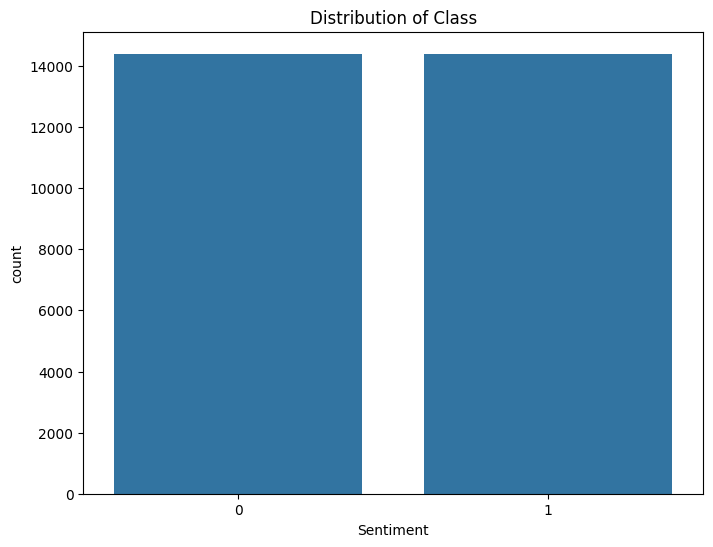

In [14]:
# Visualizations of class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Class')
plt.show()

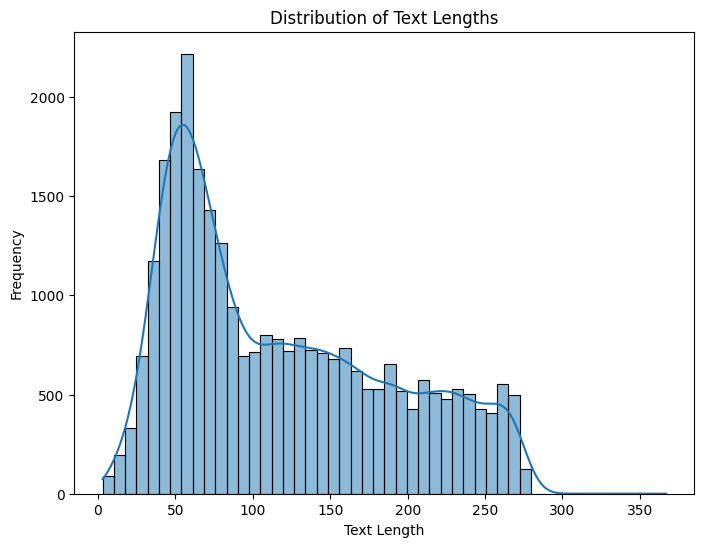

In [15]:
# Text length analysis
df['text_length'] = df['Sentences'].apply(len)
max_length = max(len(x) for x in df['Sentences'])
plt.figure(figsize=(8,6))
sns.histplot(df['text_length'], kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

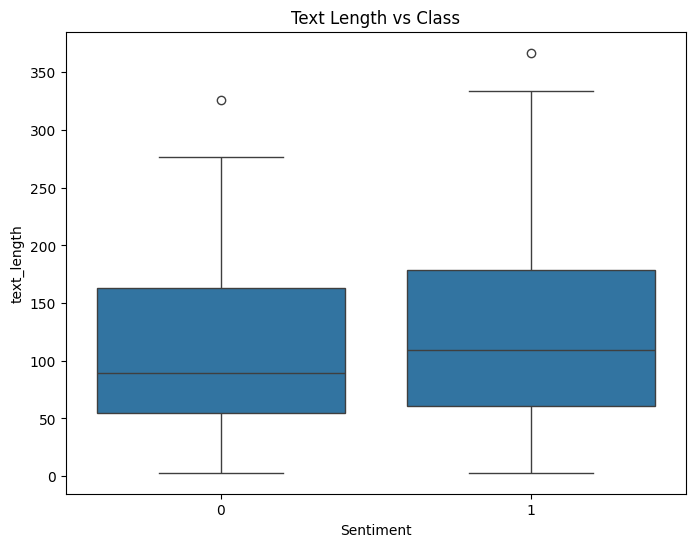

In [16]:
# Example of exploring relationship between class and text length
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sentiment', y='text_length', data=df)
plt.title('Text Length vs Class')
plt.show()

In [17]:
# Cleaning function
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^\u0900-\u097F\s]', '', text)  # Devanagari only
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespaces
    return text

# Apply cleaning
df['Cleaned_text'] = df['Sentences'].apply(clean_text)

In [18]:
nepali_stopwords = {
    'र', 'वा', 'को', 'मा', 'ले', 'का', 'कि', 'द्वारा', 'तथा', 'भए', 'छ', 'थियो', 'थिन्', 'गरेको', 'रहेको', 'गरेको', 'भएको', 'छैन', 'हो', 'हुन्', 'पनि',
    'संग', 'गरे', 'थिए', 'गर्न', 'गर्छ', 'रुपमा', 'त्यो', 'गरेका', 'गर्नु', 'जस्तै', 'एउटा', 'यदि', 'यो', 'भने', 'भइ', 'नभए'
}

nepali_punctuation = '।!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
# Preprocess Nepali text and tokenize
def preprocess_text(text):
    # Tokenize using indic-nlp-library
    tokens = indic_tokenize.trivial_tokenize(text, lang='ne')
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word
              not in nepali_stopwords and word not in nepali_punctuation]
    return tokens

df['Tokens'] = df['Sentences'].apply(preprocess_text)
print("\nSample Tokenized Data:")
print(df[['Sentences', 'Tokens']].head())


Sample Tokenized Data:
                                           Sentences  \
0  ओलि सरकार जनता को स्वास्थ्य र सुरक्षा प्रति सज...   
1  नेपालमा कोरोना भाइरस कोभिड बाट मृत्यु हुनेको स...   
2  किड्नी मस्तिष्क र मुटु सम्बन्धी रोग लागेका मान...   
3  कोभिड को संक्रमित सीताराम दाहालको पर्याप्त उपच...   
4  कोभिड का मृतक संख्यामा बेलायतले ईटालीलाई पछाडि...   

                                              Tokens  
0  [ओलि, सरकार, जनता, स्वास्थ्य, सुरक्षा, प्रति, ...  
1  [नेपालमा, कोरोना, भाइरस, कोभिड, बाट, मृत्यु, ह...  
2  [किड्नी, मस्तिष्क, मुटु, सम्बन्धी, रोग, लागेका...  
3  [कोभिड, संक्रमित, सीताराम, दाहालको, पर्याप्त, ...  
4  [कोभिड, मृतक, संख्यामा, बेलायतले, ईटालीलाई, पछ...  


In [20]:
# !pip install fasttext

In [21]:
import fasttext
# Load pre-trained model
model_path = "/content/drive/MyDrive/AI_App/cc.ne.300.bin"
# Load the binary fastText model
fasttext_model = fasttext.load_model(model_path)
print("Pre-trained fastText Nepali binary model loaded successfully.")

# Sentence vector function
def get_sentence_vector(tokens, model):
    if not tokens:
        return np.zeros(model.get_dimension(), dtype=float)
    sentence = " ".join(tokens)
    # Explicitly remove newline characters to prevent ValueError
    sentence = sentence.replace('\n', ' ').strip()
    vec = model.get_sentence_vector(sentence)  # uses subword info and averages internally
    return vec

# Apply to DataFrame
df['Sentence_Vector'] = df['Tokens'].apply(lambda toks: get_sentence_vector(toks, fasttext_model))

# Prepare feature matrix and target
X = np.vstack(df['Sentence_Vector'].values)
y = df['Sentiment'].values

print("Feature matrix shape:", X.shape)

Pre-trained fastText Nepali binary model loaded successfully.
Feature matrix shape: (28800, 300)


In [22]:
df.head()

,Sentences,Sentiment,text_length,Cleaned_text,Tokens,Sentence_Vector
0,ओलि सरकार जनता को स्वास्थ्य र सुरक्षा प्रति सज...,0,252,ओलि सरकार जनता को स्वास्थ्य र सुरक्षा प्रति सज...,"[ओलि, सरकार, जनता, स्वास्थ्य, सुरक्षा, प्रति, ...","[0.033632968, -0.038088605, -0.006125012, 0.00..."
1,नेपालमा कोरोना भाइरस कोभिड बाट मृत्यु हुनेको स...,0,71,नेपालमा कोरोना भाइरस कोभिड बाट मृत्यु हुनेको स...,"[नेपालमा, कोरोना, भाइरस, कोभिड, बाट, मृत्यु, ह...","[0.08926483, -0.04368666, -0.0155255, 0.003855..."
2,किड्नी मस्तिष्क र मुटु सम्बन्धी रोग लागेका मान...,0,61,किड्नी मस्तिष्क र मुटु सम्बन्धी रोग लागेका मान...,"[किड्नी, मस्तिष्क, मुटु, सम्बन्धी, रोग, लागेका...","[0.060382765, -0.0738056, -0.014982028, -0.020..."
3,कोभिड को संक्रमित सीताराम दाहालको पर्याप्त उपच...,0,161,कोभिड को संक्रमित सीताराम दाहालको पर्याप्त उपच...,"[कोभिड, संक्रमित, सीताराम, दाहालको, पर्याप्त, ...","[0.057664096, 0.01395908, -0.01404766, -0.0072..."
4,कोभिड का मृतक संख्यामा बेलायतले ईटालीलाई पछाडि...,0,260,कोभिड का मृतक संख्यामा बेलायतले ईटालीलाई पछाडि...,"[कोभिड, मृतक, संख्यामा, बेलायतले, ईटालीलाई, पछ...","[0.059040684, -0.07769636, -0.011217701, 0.010..."


In [23]:
df.columns

Index(['Sentences', 'Sentiment', 'text_length', 'Cleaned_text', 'Tokens',
       'Sentence_Vector'],
      dtype='object')

In [24]:
# Separate features (X) and target (y)
X = np.array(df['Sentence_Vector'].tolist())
y = df['Sentiment'].values
print("Feature matrix shape:", X.shape)

Feature matrix shape: (28800, 300)


In [25]:
df.head()

,Sentences,Sentiment,text_length,Cleaned_text,Tokens,Sentence_Vector
0,ओलि सरकार जनता को स्वास्थ्य र सुरक्षा प्रति सज...,0,252,ओलि सरकार जनता को स्वास्थ्य र सुरक्षा प्रति सज...,"[ओलि, सरकार, जनता, स्वास्थ्य, सुरक्षा, प्रति, ...","[0.033632968, -0.038088605, -0.006125012, 0.00..."
1,नेपालमा कोरोना भाइरस कोभिड बाट मृत्यु हुनेको स...,0,71,नेपालमा कोरोना भाइरस कोभिड बाट मृत्यु हुनेको स...,"[नेपालमा, कोरोना, भाइरस, कोभिड, बाट, मृत्यु, ह...","[0.08926483, -0.04368666, -0.0155255, 0.003855..."
2,किड्नी मस्तिष्क र मुटु सम्बन्धी रोग लागेका मान...,0,61,किड्नी मस्तिष्क र मुटु सम्बन्धी रोग लागेका मान...,"[किड्नी, मस्तिष्क, मुटु, सम्बन्धी, रोग, लागेका...","[0.060382765, -0.0738056, -0.014982028, -0.020..."
3,कोभिड को संक्रमित सीताराम दाहालको पर्याप्त उपच...,0,161,कोभिड को संक्रमित सीताराम दाहालको पर्याप्त उपच...,"[कोभिड, संक्रमित, सीताराम, दाहालको, पर्याप्त, ...","[0.057664096, 0.01395908, -0.01404766, -0.0072..."
4,कोभिड का मृतक संख्यामा बेलायतले ईटालीलाई पछाडि...,0,260,कोभिड का मृतक संख्यामा बेलायतले ईटालीलाई पछाडि...,"[कोभिड, मृतक, संख्यामा, बेलायतले, ईटालीलाई, पछ...","[0.059040684, -0.07769636, -0.011217701, 0.010..."


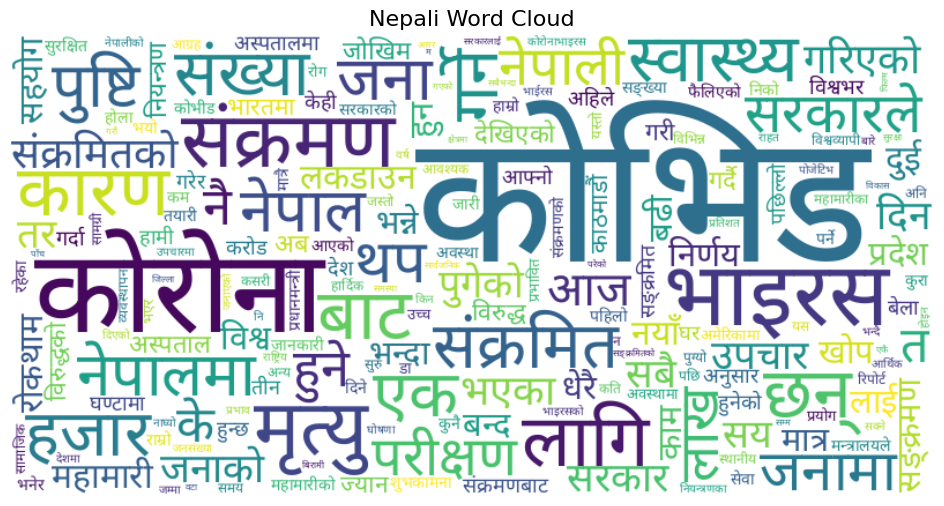

In [26]:
from collections import Counter
from wordcloud import WordCloud

# Combine all tokens into a single flat list
all_tokens = [token for tokens in df['Tokens'] for token in tokens]

# Create a frequency dictionary
word_freq = Counter(all_tokens)

# Define path to font
font_path = "/content/drive/MyDrive/AI_App/Devanagari Font/NotoSansDevanagari-VariableFont_wdth,wght.ttf"

# Create word cloud from frequency
wordcloud = WordCloud(
    font_path=font_path,
    width=800,
    height=400,
    background_color='white',
    collocations=False
).generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nepali Word Cloud", fontsize=16)
plt.show()

In [27]:
df.columns

Index(['Sentences', 'Sentiment', 'text_length', 'Cleaned_text', 'Tokens',
       'Sentence_Vector'],
      dtype='object')

In [28]:
# Drop unnecessary columns
df = df.drop(columns=["Sentences","Cleaned_text","Tokens","text_length"], errors='ignore')
df = df.dropna(subset=["Sentence_Vector", "Sentiment"])
df.head()

,Sentiment,Sentence_Vector
0,0,"[0.033632968, -0.038088605, -0.006125012, 0.00..."
1,0,"[0.08926483, -0.04368666, -0.0155255, 0.003855..."
2,0,"[0.060382765, -0.0738056, -0.014982028, -0.020..."
3,0,"[0.057664096, 0.01395908, -0.01404766, -0.0072..."
4,0,"[0.059040684, -0.07769636, -0.011217701, 0.010..."


In [29]:
# Set random seed for reproducibility
RANDOM_STATE = 42

# Split into train and temp (70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y  # Preserves sentiment class balance
)

# Split temp into validation and test (each 15% of original)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

# Print sizes to confirm
print(f"Train size     : {X_train.shape}")
print(f"Validation size: {X_val.shape}")
print(f"Test size      : {X_test.shape}")

Train size     : (20160, 300)
Validation size: (4320, 300)
Test size      : (4320, 300)


In [30]:
from sklearn.model_selection import GridSearchCV

In [31]:
param_grid = {
    'C': [0.5, 2, 8],
    'gamma': ['scale', 0.01],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

svm = SVC(random_state=42)

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring='accuracy'
)

In [32]:
# Fit the model on training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.5, 2, 8], 'class_weight': ['balanced'],
                         'gamma': ['scale', 0.01], 'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [33]:
results = pd.DataFrame(grid_search.cv_results_)

results = results[[
    'param_C',
    'param_gamma',
    'param_kernel',
    'param_class_weight',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]].sort_values('rank_test_score')

print(results.to_string(index=False))

 param_C param_gamma param_kernel param_class_weight  mean_test_score  std_test_score  rank_test_score
     2.0       scale          rbf           balanced         0.817262        0.002511                1
     8.0       scale          rbf           balanced         0.814038        0.004739                2
     0.5       scale          rbf           balanced         0.804563        0.002351                3
     8.0        0.01          rbf           balanced         0.772123        0.006576                4
     2.0        0.01          rbf           balanced         0.753671        0.005468                5
     0.5        0.01          rbf           balanced         0.711607        0.005651                6


In [34]:
# Best model and parameters
best_svm = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 2, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


In [35]:
# Evaluate on validation set
y_val_pred = best_svm.predict(X_val)
print("\nValidation Set Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))


Validation Set Evaluation:
Accuracy: 0.837037037037037
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      2160
           1       0.84      0.83      0.84      2160

    accuracy                           0.84      4320
   macro avg       0.84      0.84      0.84      4320
weighted avg       0.84      0.84      0.84      4320

Confusion Matrix:
 [[1814  346]
 [ 358 1802]]


In [36]:
# Evaluate on test set
y_test_pred = best_svm.predict(X_test)
print("\nTest Set Evaluation:")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Test Set Evaluation:
Test Accuracy: 0.8226851851851852
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      2160
           1       0.82      0.83      0.82      2160

    accuracy                           0.82      4320
   macro avg       0.82      0.82      0.82      4320
weighted avg       0.82      0.82      0.82      4320

Confusion Matrix:
 [[1765  395]
 [ 371 1789]]


In [37]:
# Confusion Matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.tight_layout()
    plt.show()

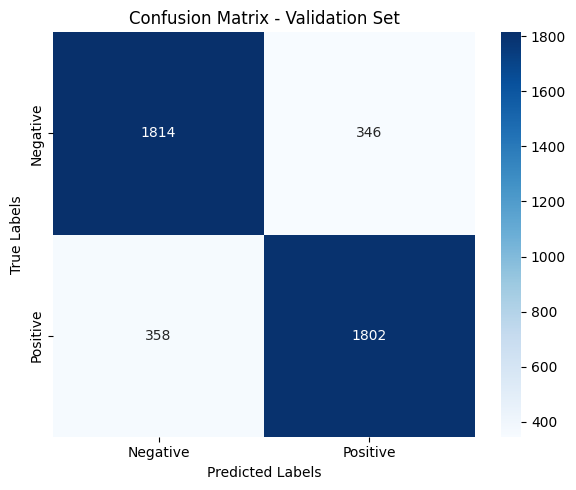

In [38]:
# Plot for Validation Set
plot_conf_matrix(y_val, y_val_pred, 'Confusion Matrix - Validation Set')

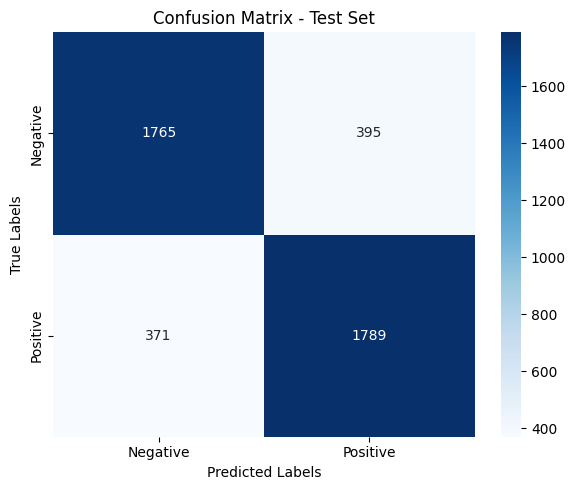

In [39]:
# Plot for Test Set
plot_conf_matrix(y_test, y_test_pred, 'Confusion Matrix - Test Set')

In [40]:
# Compute metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

val_f1 = f1_score(y_val, y_val_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

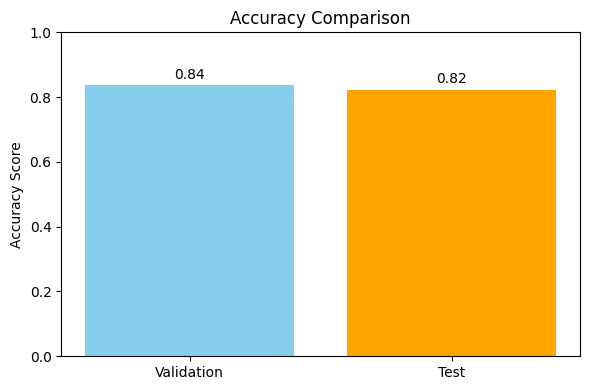

In [41]:
# Accuracy comparison
plt.figure(figsize=(6, 4))
plt.bar(['Validation', 'Test'], [val_accuracy, test_accuracy], color=['skyblue', 'orange'])
plt.ylim(0, 1)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy Score')
for i, score in enumerate([val_accuracy, test_accuracy]):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center')
plt.tight_layout()
plt.show()

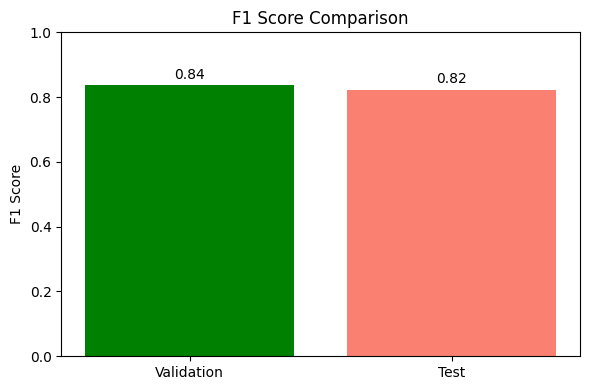

In [42]:
# F1 Score comparison
plt.figure(figsize=(6, 4))
plt.bar(['Validation', 'Test'], [val_f1, test_f1], color=['green', 'salmon'])
plt.ylim(0, 1)
plt.title('F1 Score Comparison')
plt.ylabel('F1 Score')
for i, score in enumerate([val_f1, test_f1]):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center')
plt.tight_layout()
plt.show()

In [43]:
# !pip install joblib

In [44]:
import joblib

# Save the model to a file
joblib.dump(best_svm, 'svm_nepali_sentiment_model.pkl')
print("Model saved to 'svm_nepali_sentiment_model.pkl'")

Model saved to 'svm_nepali_sentiment_model.pkl'
